# Neural Network

In [1]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout

In [2]:
"Read in clean-data"
df = pd.read_csv("clean_df.csv")

In [3]:
"Configure features and target"
# Define target column
target_col = "Price"

# Split features/target
x = df.drop(columns=[target_col])
y = df[target_col].astype(float)

In [4]:
"Configure features and target"
# Define target column
target_col = "Price"

# Split features/target
x = df.drop(columns=[target_col])
y = df[target_col].astype(float)

In [5]:
"Split data into training and test sets"
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [ ]:
"Preprocess data"
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# Preprocessor OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough' 
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names = (
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist() +
    numerical_cols
)

X_train = X_train_processed
X_test = X_test_processed

In [8]:
"Cross-validation setup"
k_folds = 5 # Number of folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define parameter grid to test 
param_combinations = [
    {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'hidden_size': 64},
    {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'hidden_size': 128},
    {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64},
]

In [10]:
"Cross-validation function"
def cv_params(X_train, y_train, param_list, k_folds=5):
    """Cross-validation for neural network hyperparameters"""
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    best_score, best_params = float('inf'), None
    
    for i, params in enumerate(param_list):
        print(f"\nTesting {i+1}/{len(param_list)}: {params}")
        scores = []
        
        # Split and scale data
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_train[train_idx])
            X_val = scaler.transform(X_train[val_idx])
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Build model
            model = Sequential([
                Input(shape=(X_tr.shape[1],)),
                Dense(params['hidden_size'], activation='relu'),
                Dense(params['hidden_size']//2, activation='relu'),
                Dense(params['hidden_size']//4, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse')
            
            # Train
            model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'],
                     validation_data=(X_val, y_val), verbose=0,
                     callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
            
            # Evaluate
            score = mean_squared_error(y_val, model.predict(X_val, verbose=0))
            scores.append(score)
            print(f"  Fold {fold+1}: {score:.4f}")
        
        # Track best
        avg_score = np.mean(scores)
        print(f"  Average: {avg_score:.4f} ± {np.std(scores):.4f}")
        
        if avg_score < best_score:
            best_score, best_params = avg_score, params
    
    print(f"Best: {best_params} (MSE: {best_score:.4f})")
    return best_params, best_score, []

In [11]:
"Run cross-validation to find best parameters"
best_params, best_score, all_results = cv_params(
    X_train, y_train, 
    param_combinations, 
    k_folds=5
)

print("\nAll parameter combinations tested:")
for i, result in enumerate(all_results):
    print(f"\n{i+1}. {result['params']}")
    print(f"   Average MSE: {result['avg_score']:.4f} ± {result['std_score']:.4f}")
    print(f"   Fold scores: {[f'{score:.4f}' for score in result['fold_scores']]}")

# Print best parameters
print(f"   BEST PARAMETERS FOUND:")
print(f"   Parameters: {best_params}")
print(f"   Best CV Score (MSE): {best_score:.4f}")
print(f"   Best CV Score (RMSE): {np.sqrt(best_score):.4f}")




Testing 1/3: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'hidden_size': 64}
  Fold 1: 48546.1597
  Fold 2: 46966.4752
  Fold 3: 47464.6143
  Fold 4: 51611.6184
  Fold 5: 38058.4779
  Average: 46529.4691 ± 4532.5146

Testing 2/3: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'hidden_size': 128}
  Fold 1: 56142.7803
  Fold 2: 30736.7306
  Fold 3: 107378.3163
  Fold 4: 110520.0983
  Fold 5: 83674.1139
  Average: 77690.4079 ± 30541.4907

Testing 3/3: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64}
  Fold 1: 35943.4671
  Fold 2: 43997.5099
  Fold 3: 36237.6960
  Fold 4: 40260.5512
  Fold 5: 37866.0298
  Average: 38861.0508 ± 2990.8583
Best: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64} (MSE: 38861.0508)

All parameter combinations tested:
   BEST PARAMETERS FOUND:
   Parameters: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64}
   Best CV Score (MSE): 38861.0508
   Best CV Score (R

In [12]:
"Training final model with best parameters"

# Scale the full training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create final model with best params
def create_final_model(params, input_dim):
    model = Sequential([
        Dense(params['hidden_size'], activation='relu', input_dim=input_dim),
        Dense(params['hidden_size']//2, activation='relu'),
        Dense(params['hidden_size']//4, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return model

# Train final model
final_model = create_final_model(best_params, X_train_scaled.shape[1])

history = final_model.fit(
    X_train_scaled, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,  # Use 20% of training data for monitoring
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
)

print("Final model training complete!")

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - loss: 408601504.0000 - mae: 12549.5215 - val_loss: 56258108.0000 - val_mae: 3892.4429
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 46589016.0000 - mae: 3525.1570 - val_loss: 29676566.0000 - val_mae: 2722.2676
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 28554242.0000 - mae: 2723.6167 - val_loss: 22265528.0000 - val_mae: 2408.4312
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 24493636.0000 - mae: 2439.2188 - val_loss: 17738326.0000 - val_mae: 1974.4475
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 18804620.0000 - mae: 1988.5173 - val_loss: 14045222.0000 - val_mae: 1517.2126
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 14759601.0000 - mae: 1563.3882 - val_loss: 10473193.0000 - val_mae: 1196.8888
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 9736854.0000 - mae: 1176.7682 - val_loss: 7632082.5000 - val_mae: 1022.2470
Epoch 8/100
500/500 ━━━━━

In [13]:
"Newtwork summary and size"
final_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,677 (49.52 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,452 (33.02 KB)

   Final test results:
   Mean Squared Error (MSE): 40393.0880
   Root Mean Squared Error (RMSE): 200.9803
   Mean Absolute Error (MAE): 133.4112
   R² Score: 0.9999
   Comparison:
   Cross-Validation RMSE: 197.1321
   Final Test RMSE: 200.9803
   Difference: 3.8483


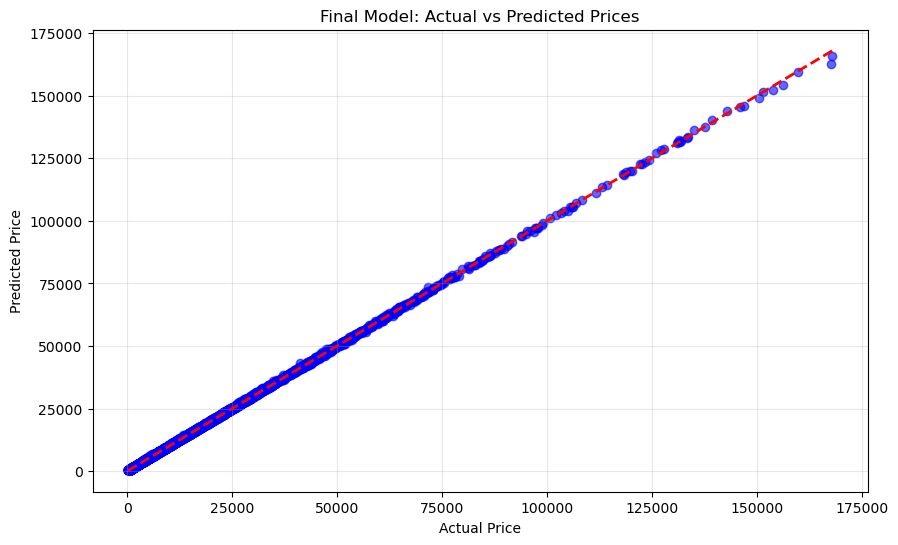

In [14]:
"Evaluate final model on test set"

# Make predictions on test set
test_predictions = final_model.predict(X_test_scaled, verbose=0)

# Calculate metrics
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

# Print results
print(f"   Final test results:")
print(f"   Mean Squared Error (MSE): {mse:.4f}")
print(f"   Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"   Mean Absolute Error (MAE): {mae:.4f}")
print(f"   R² Score: {r2:.4f}")

print(f"   Comparison:")
print(f"   Cross-Validation RMSE: {np.sqrt(best_score):.4f}")
print(f"   Final Test RMSE: {rmse:.4f}")
print(f"   Difference: {abs(rmse - np.sqrt(best_score)):.4f}")

# Plot (predictions vs actual)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Final Model: Actual vs Predicted Prices')
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
"Save model"

# Metadata
model_info = {
    'best_params': best_params,
    'best_score': best_score,
    'feature_names': feature_names,
    'model_type': 'neural_network'
}

joblib.dump({
    'model': final_model,
    'scaler': scaler,
    'preprocessor': preprocessor,
    'feature_names': feature_names,
    'metadata': model_info
}, 'NN_model.joblib')

# Load
loaded = joblib.load('NN_model.joblib')
model = loaded['model']
scaler = loaded['scaler']
preprocessor = loaded['preprocessor']

In [17]:
def predict_price(new_data):
    # Preprocess (handles encoding automatically)
    new_data_processed = preprocessor.transform(new_data)
    
    # Scale
    new_data_scaled = scaler.transform(new_data_processed)
    
    # Predict
    prediction = model.predict(new_data_scaled)
    
    return prediction[0][0]  # scalar output

In [18]:
"Example"
new_car_data = pd.DataFrame({
    'Manufacturer': ['Toyota'],
    'Model': ['Yaris'],
    'Engine size': [1.5],
    'Fuel type': ['Petrol'],
    'Year of manufacture': [2018],
    'Mileage': [25000],
    'Car Age': [2022 - 2018]
})

predicted_price = predict_price(new_car_data)
print("Predicted price:", predicted_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted price: 25464.797


In [19]:
"Test prediction on samples from test set"
sample_new_data = X_test[:5].copy()  # Test samples (numpy indexing)
actual_prices = y_test.iloc[:5].copy()  # Actual prices (for comparison)

for i in range(len(sample_new_data)):
    sample_scaled = scaler.transform([sample_new_data[i]])  # Changed indexing here too

    # Make prediction
    predicted_price = model.predict(sample_scaled, verbose=0)[0][0]
    actual_price = actual_prices.iloc[i]
    
    print(f"Sample {i+1}:")
    print(f"  Predicted Price: ${predicted_price:,.2f}")
    print(f"  Actual Price:    ${actual_price:,.2f}")
    print(f"  Error:           ${abs(predicted_price - actual_price):,.2f}\n")

Sample 1:
  Predicted Price: $28,784.18
  Actual Price:    $28,636.00
  Error:           $148.18

Sample 2:
  Predicted Price: $59,692.89
  Actual Price:    $59,783.00
  Error:           $90.11

Sample 3:
  Predicted Price: $14,745.87
  Actual Price:    $14,865.00
  Error:           $119.13

Sample 4:
  Predicted Price: $2,049.33
  Actual Price:    $2,219.00
  Error:           $169.67

Sample 5:
  Predicted Price: $902.06
  Actual Price:    $1,001.00
  Error:           $98.94



  Processed 1/24 features...
  Processed 11/24 features...
  Processed 21/24 features...


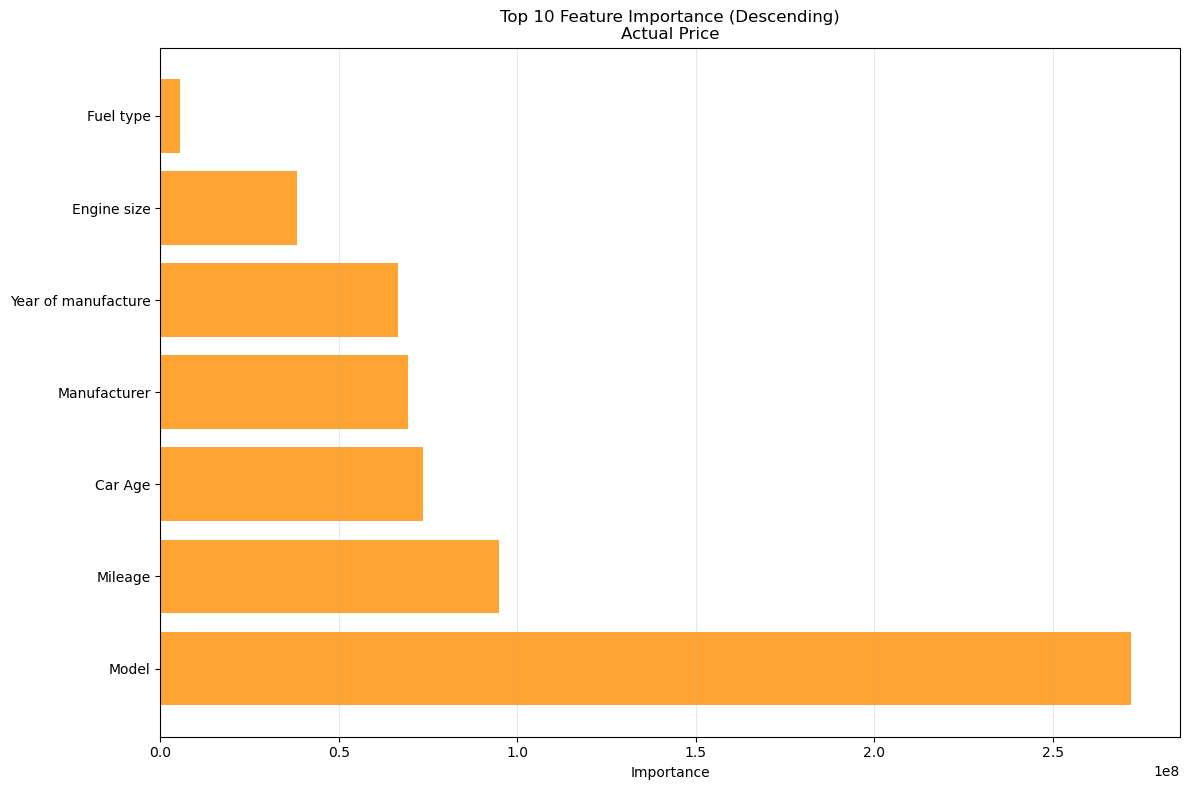

In [21]:
"Feature importance by permutation"
baseline_predictions = final_model.predict(X_test_scaled, verbose=0).flatten()
baseline_mse = mean_squared_error(y_test, baseline_predictions)

# Calculate importance for each feature
feature_importance_scores = []

for i, feature_name in enumerate(feature_names):  # Changed here
    X_test_permuted = X_test_scaled.copy()
    np.random.seed(42)
    X_test_permuted[:, i] = np.random.permutation(X_test_permuted[:, i])
    permuted_predictions = final_model.predict(X_test_permuted, verbose=0).flatten()
    permuted_mse = mean_squared_error(y_test, permuted_predictions)
    
    # Calculate importance 
    importance = permuted_mse - baseline_mse
    feature_importance_scores.append(importance)
    
    if i % 10 == 0: 
        print(f"  Processed {i+1}/{len(feature_names)} features...")  # Changed here

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Changed here
    'Importance': feature_importance_scores
})

def group_feature_importance(df):
    grouped_importance = {}
    
    for _, row in df.iterrows():
        feature_name = row['Feature']
        importance = row['Importance']
        
        if feature_name.startswith('Manufacturer_'):
            category = 'Manufacturer'
        elif feature_name.startswith('Model_'):
            category = 'Model'
        elif feature_name.startswith('Fuel type_'):
            category = 'Fuel type'
        else:
            category = feature_name
        if category in grouped_importance:
            grouped_importance[category] += importance
        else:
            grouped_importance[category] = importance
    
    return grouped_importance

# Group features
grouped_scores = group_feature_importance(feature_importance_df)

# Sort
sort_descending = True 

grouped_df = pd.DataFrame(list(grouped_scores.items()), 
                         columns=['Feature', 'Importance']).sort_values('Importance', ascending=True)

# Plot top 10 features
plt.figure(figsize=(12, 8))
top_features = grouped_df.head(10)  # Top 10 grouped features

plt.barh(range(len(top_features)), top_features['Importance'], 
         color='#FF8C00', alpha=0.8)  # Orange color

# Labels
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')

sort_label = "Descending" if sort_descending else "Ascending"
plt.title(f'Top 10 Feature Importance ({sort_label})\nActual Price')

if sort_descending:
    plt.gca().invert_yaxis()

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [22]:
"SHAP"
# Use smaller sample for faster computation
n_background = 50  # Background samples
n_explain = 10     # Samples to explain

# Create wrapper function
def model_predict_shap(X):
    return final_model.predict(X, verbose=0).flatten()

# Use KernelExplainer instead of DeepExplainer
explainer = shap.KernelExplainer(model_predict_shap, X_train_scaled[:n_background])
shap_values = explainer.shap_values(X_test_scaled[:n_explain])

# Simple feature importance from SHAP
feature_importance = np.mean(np.abs(shap_values), axis=0)
shap_df = pd.DataFrame({
    'Feature': feature_names,  # Changed here
    'SHAP_Importance': feature_importance
}).sort_values('SHAP_Importance', ascending=False)

print("Top 7 Features by SHAP:")
print(shap_df.head(7))

  0%|          | 0/10 [00:00<?, ?it/s]

Top 7 Features by SHAP:
                 Feature  SHAP_Importance
22               Mileage      5877.270457
9               Model_M5      5030.997206
23               Car Age      5000.127252
21   Year of manufacture      4718.180571
20           Engine size      2540.467095
1   Manufacturer_Porsche      1303.072633
14            Model_RAV4      1168.066686
